In [10]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K


def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

# model.add(Lambda(antirectifier, output_shape=antirectifier_output_shape))


lr = 2e-4  # 0.0002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)


def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=None, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()  # (Batch, ni_D)
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))  # (Batch, steps=ni_D, input_dim=1)
        G.add(Conv1D(nh_G, 1, activation='relu'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
        G.add(Flatten())  # (Batch, ni_D)

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)


class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)


class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # print(Real.shape)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)
        # print(Gen.shape)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        """
        generate a new image
        """
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        """
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        """
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))


# class GAN_Pure(GAN):
#     def __init__(self, ni_D, nh_D, nh_G):
#         '''
#         Discriminator input is not added
#         '''
#         super().__init__(ni_D, nh_D, nh_G)

#     def gen_D(self):
#         ni_D = self.ni_D
#         nh_D = self.nh_D
#         D = models.Sequential()
#         # D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
#         D.add(Dense(nh_D, activation='relu', input_shape=(ni_D,)))
#         D.add(Dense(nh_D, activation='relu'))
#         D.add(Dense(1, activation='sigmoid'))

#         model_compile(D)
#         return D


# class Machine_Pure(Machine):
#     def __init__(self, n_batch=10, ni_D=100):
#         data_mean = 4
#         data_stddev = 1.25

#         self.data = Data(data_mean, data_stddev, ni_D)
#         self.gan = GAN_Pure(ni_D=ni_D, nh_D=50, nh_G=50)

#         self.n_batch = n_batch
#         # self.ni_D = ni_D


def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=20, n_show=200, n_test=100)

Stage 0 (Epoch: 0)
Mean and Std of Real: (4.003715730666138, 1.2671679485909064)
Mean and Std of Gen: (2.773533, 0.8774564)


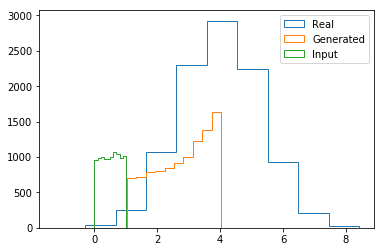

Stage 1 (Epoch: 200)
Mean and Std of Real: (4.006383249951154, 1.2598776836079206)
Mean and Std of Gen: (4.038216, 1.3848442)


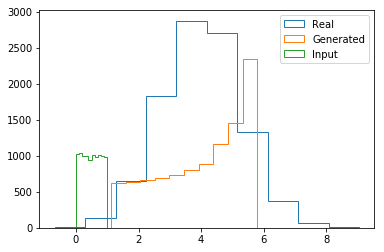

Stage 2 (Epoch: 400)
Mean and Std of Real: (4.005015520596299, 1.2430637308497041)
Mean and Std of Gen: (4.6469264, 1.1897103)


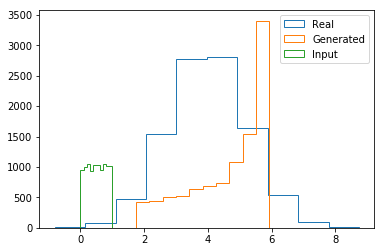

Stage 3 (Epoch: 600)
Mean and Std of Real: (4.010221463910346, 1.2359950921322984)
Mean and Std of Gen: (4.8129234, 1.3043587)


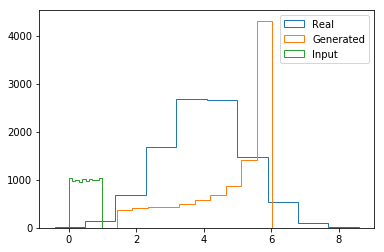

Stage 4 (Epoch: 800)
Mean and Std of Real: (4.002471680947971, 1.2498181506138428)
Mean and Std of Gen: (4.7337756, 1.4234512)


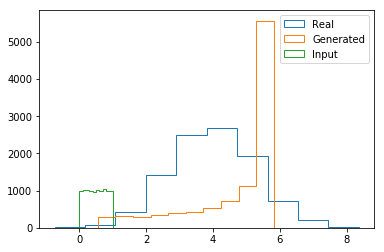

Stage 5 (Epoch: 1000)
Mean and Std of Real: (4.010555178664058, 1.2613313289792198)
Mean and Std of Gen: (4.475818, 1.2895991)


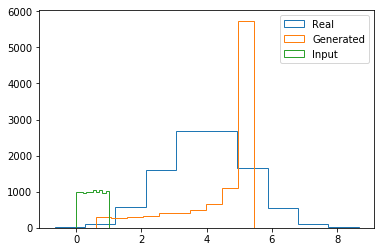

Stage 6 (Epoch: 1200)
Mean and Std of Real: (3.9988579381536264, 1.2525709140089292)
Mean and Std of Gen: (4.2458463, 1.2986288)


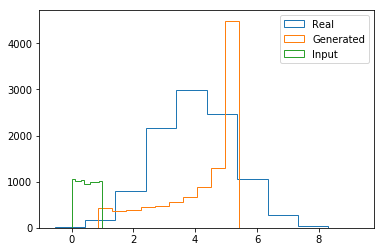

Stage 7 (Epoch: 1400)
Mean and Std of Real: (4.000971964672858, 1.2525055683558444)
Mean and Std of Gen: (4.4299235, 1.2979014)


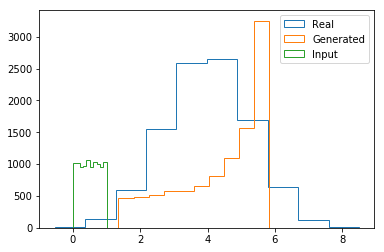

Stage 8 (Epoch: 1600)
Mean and Std of Real: (4.020095333940695, 1.2418561006116646)
Mean and Std of Gen: (4.212029, 1.1855332)


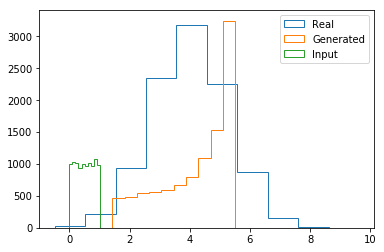

Stage 9 (Epoch: 1800)
Mean and Std of Real: (4.002486362971157, 1.2514639517066315)
Mean and Std of Gen: (4.1293697, 1.1933707)


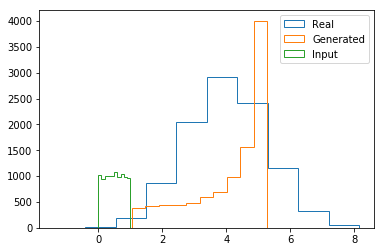

Stage 10 (Epoch: 2000)
Mean and Std of Real: (3.9959450109976156, 1.2408122359496998)
Mean and Std of Gen: (4.482799, 1.1859039)


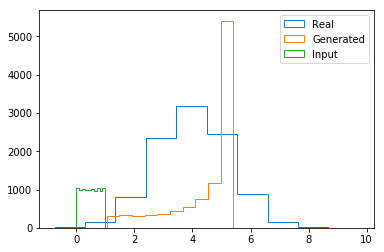

Stage 11 (Epoch: 2200)
Mean and Std of Real: (4.005356522833548, 1.2572132710020925)
Mean and Std of Gen: (3.8270867, 1.2978435)


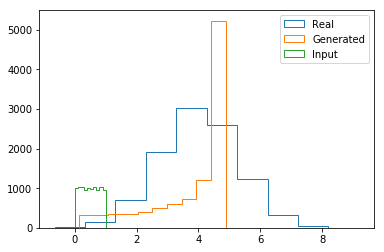

Stage 12 (Epoch: 2400)
Mean and Std of Real: (3.9835763217876607, 1.2413923037283712)
Mean and Std of Gen: (4.3012867, 1.2292895)


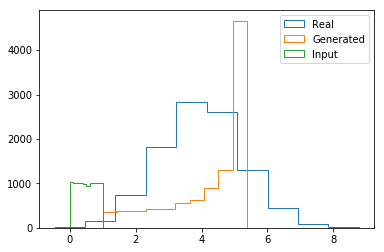

Stage 13 (Epoch: 2600)
Mean and Std of Real: (4.017479313483522, 1.2648589721830774)
Mean and Std of Gen: (4.1462517, 1.3114523)


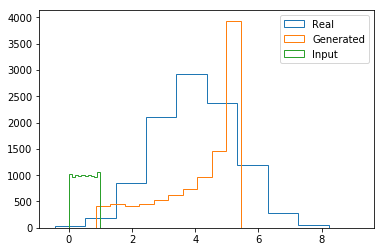

Stage 14 (Epoch: 2800)
Mean and Std of Real: (4.008335596623496, 1.2461857849189943)
Mean and Std of Gen: (3.8141434, 1.3886303)


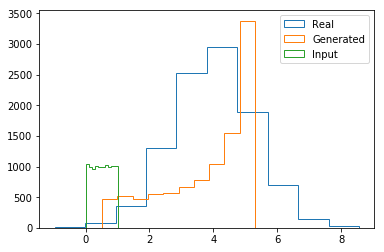

Stage 15 (Epoch: 3000)
Mean and Std of Real: (4.0014700139656325, 1.2573059568283316)
Mean and Std of Gen: (3.7163858, 1.4100572)


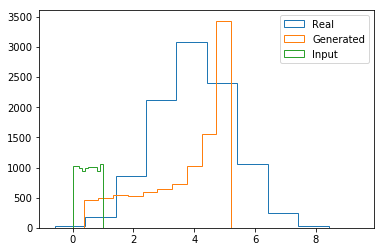

Stage 16 (Epoch: 3200)
Mean and Std of Real: (3.9904960800479072, 1.256451126841608)
Mean and Std of Gen: (3.911317, 1.1526186)


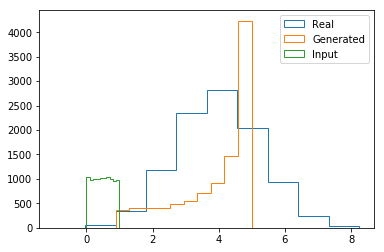

Stage 17 (Epoch: 3400)
Mean and Std of Real: (4.005281214985902, 1.253081635937225)
Mean and Std of Gen: (3.9273624, 1.1349405)


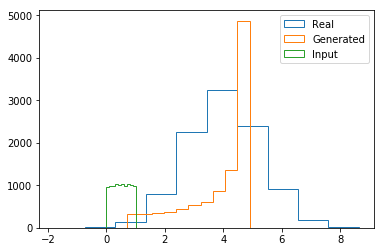

Stage 18 (Epoch: 3600)
Mean and Std of Real: (4.012106857813246, 1.248982204008355)
Mean and Std of Gen: (4.553294, 1.2213348)


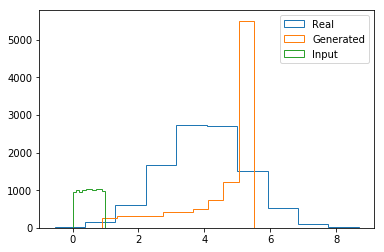

Stage 19 (Epoch: 3800)
Mean and Std of Real: (4.01278090542339, 1.245323446720757)
Mean and Std of Gen: (4.309498, 1.196441)


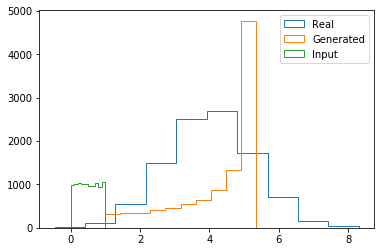

In [11]:
main()